In [2]:
import os
import random
import sys
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from ale_py import ALEInterface
from stable_baselines3 import DQN
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack

sys.path.append(os.path.abspath(os.path.join("../..")))

from rl_explainer.saliency_maps import (
    GradCAM,
    GuidedBackprop,
    GuidedGradCAM,
    ScoreCAM,
    SmoothGrad,
    VanillaGrad,
)

ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.11.1+2750686)
[Powered by Stella]


In [21]:
ENV_NAME = "BreakoutNoFrameskip-v4"
MODEL_PATH = "../models/breakout_ec2_2nd_try/rl_model_8000000_steps.zip"
ENV_SEED = 165934
RANDOM_SEED = 21115

In [4]:
dqn_model = DQN.load(MODEL_PATH)

/Users/miguel.jimenez/.pyenv/versions/3.13.3/envs/rl-explainer/lib/python3.13/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute 'ConstantSchedule' on <module 'stable_baselines3.common.utils' from '/Users/miguel.jimenez/.pyenv/versions/3.13.3/envs/rl-explainer/lib/python3.13/site-packages/stable_baselines3/common/utils.py'>
  warnings.warn(
/Users/miguel.jimenez/.pyenv/versions/3.13.3/envs/rl-explainer/lib/python3.13/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute 'FloatSchedule' on <module 'stable_baselines3.common.utils' from '/Users/miguel.jimenez/.pyenv/versions/3.13.3/envs/rl-explainer/lib/python3.13/site-packages/stable_baselines3/common/utils.py'>
  warnings.warn(
/

In [5]:
@dataclass
class Transition:
    state: np.ndarray
    action: np.int64
    reward: np.float32
    new_state: np.ndarray

In [6]:
# get an obervation of the game
env = make_vec_env(ENV_NAME, n_envs=1, wrapper_class=AtariWrapper)
env = VecFrameStack(env, n_stack=4)
env.seed(ENV_SEED)
transitions = []

n_episodes = 3
for _ in range(n_episodes):
    obs = env.reset()
    done = [False]
    while not done[0]:
        action, _ = dqn_model.predict(obs, deterministic=True)
        new_obs, reward, done, _ = env.step(action)

        transitions.append(
            Transition(
                state=obs,
                action=action,
                reward=reward[0],
                new_state=new_obs,
            )
        )

        obs = new_obs
        env.render("human")

env.close()

A.L.E: Arcade Learning Environment (version 0.11.1+2750686)
[Powered by Stella]


In [7]:
target_layer = dqn_model.q_net.features_extractor.cnn[4]

vanilla_grad = VanillaGrad(dqn_model)
smooth_grad = SmoothGrad(vanilla_grad)
guided_backprop = GuidedBackprop(dqn_model)
score_cam = ScoreCAM(dqn_model, target_layer=4)
grad_cam = GradCAM(dqn_model, target_layer)
guided_grad_cam = GuidedGradCAM(dqn_model, target_layer)

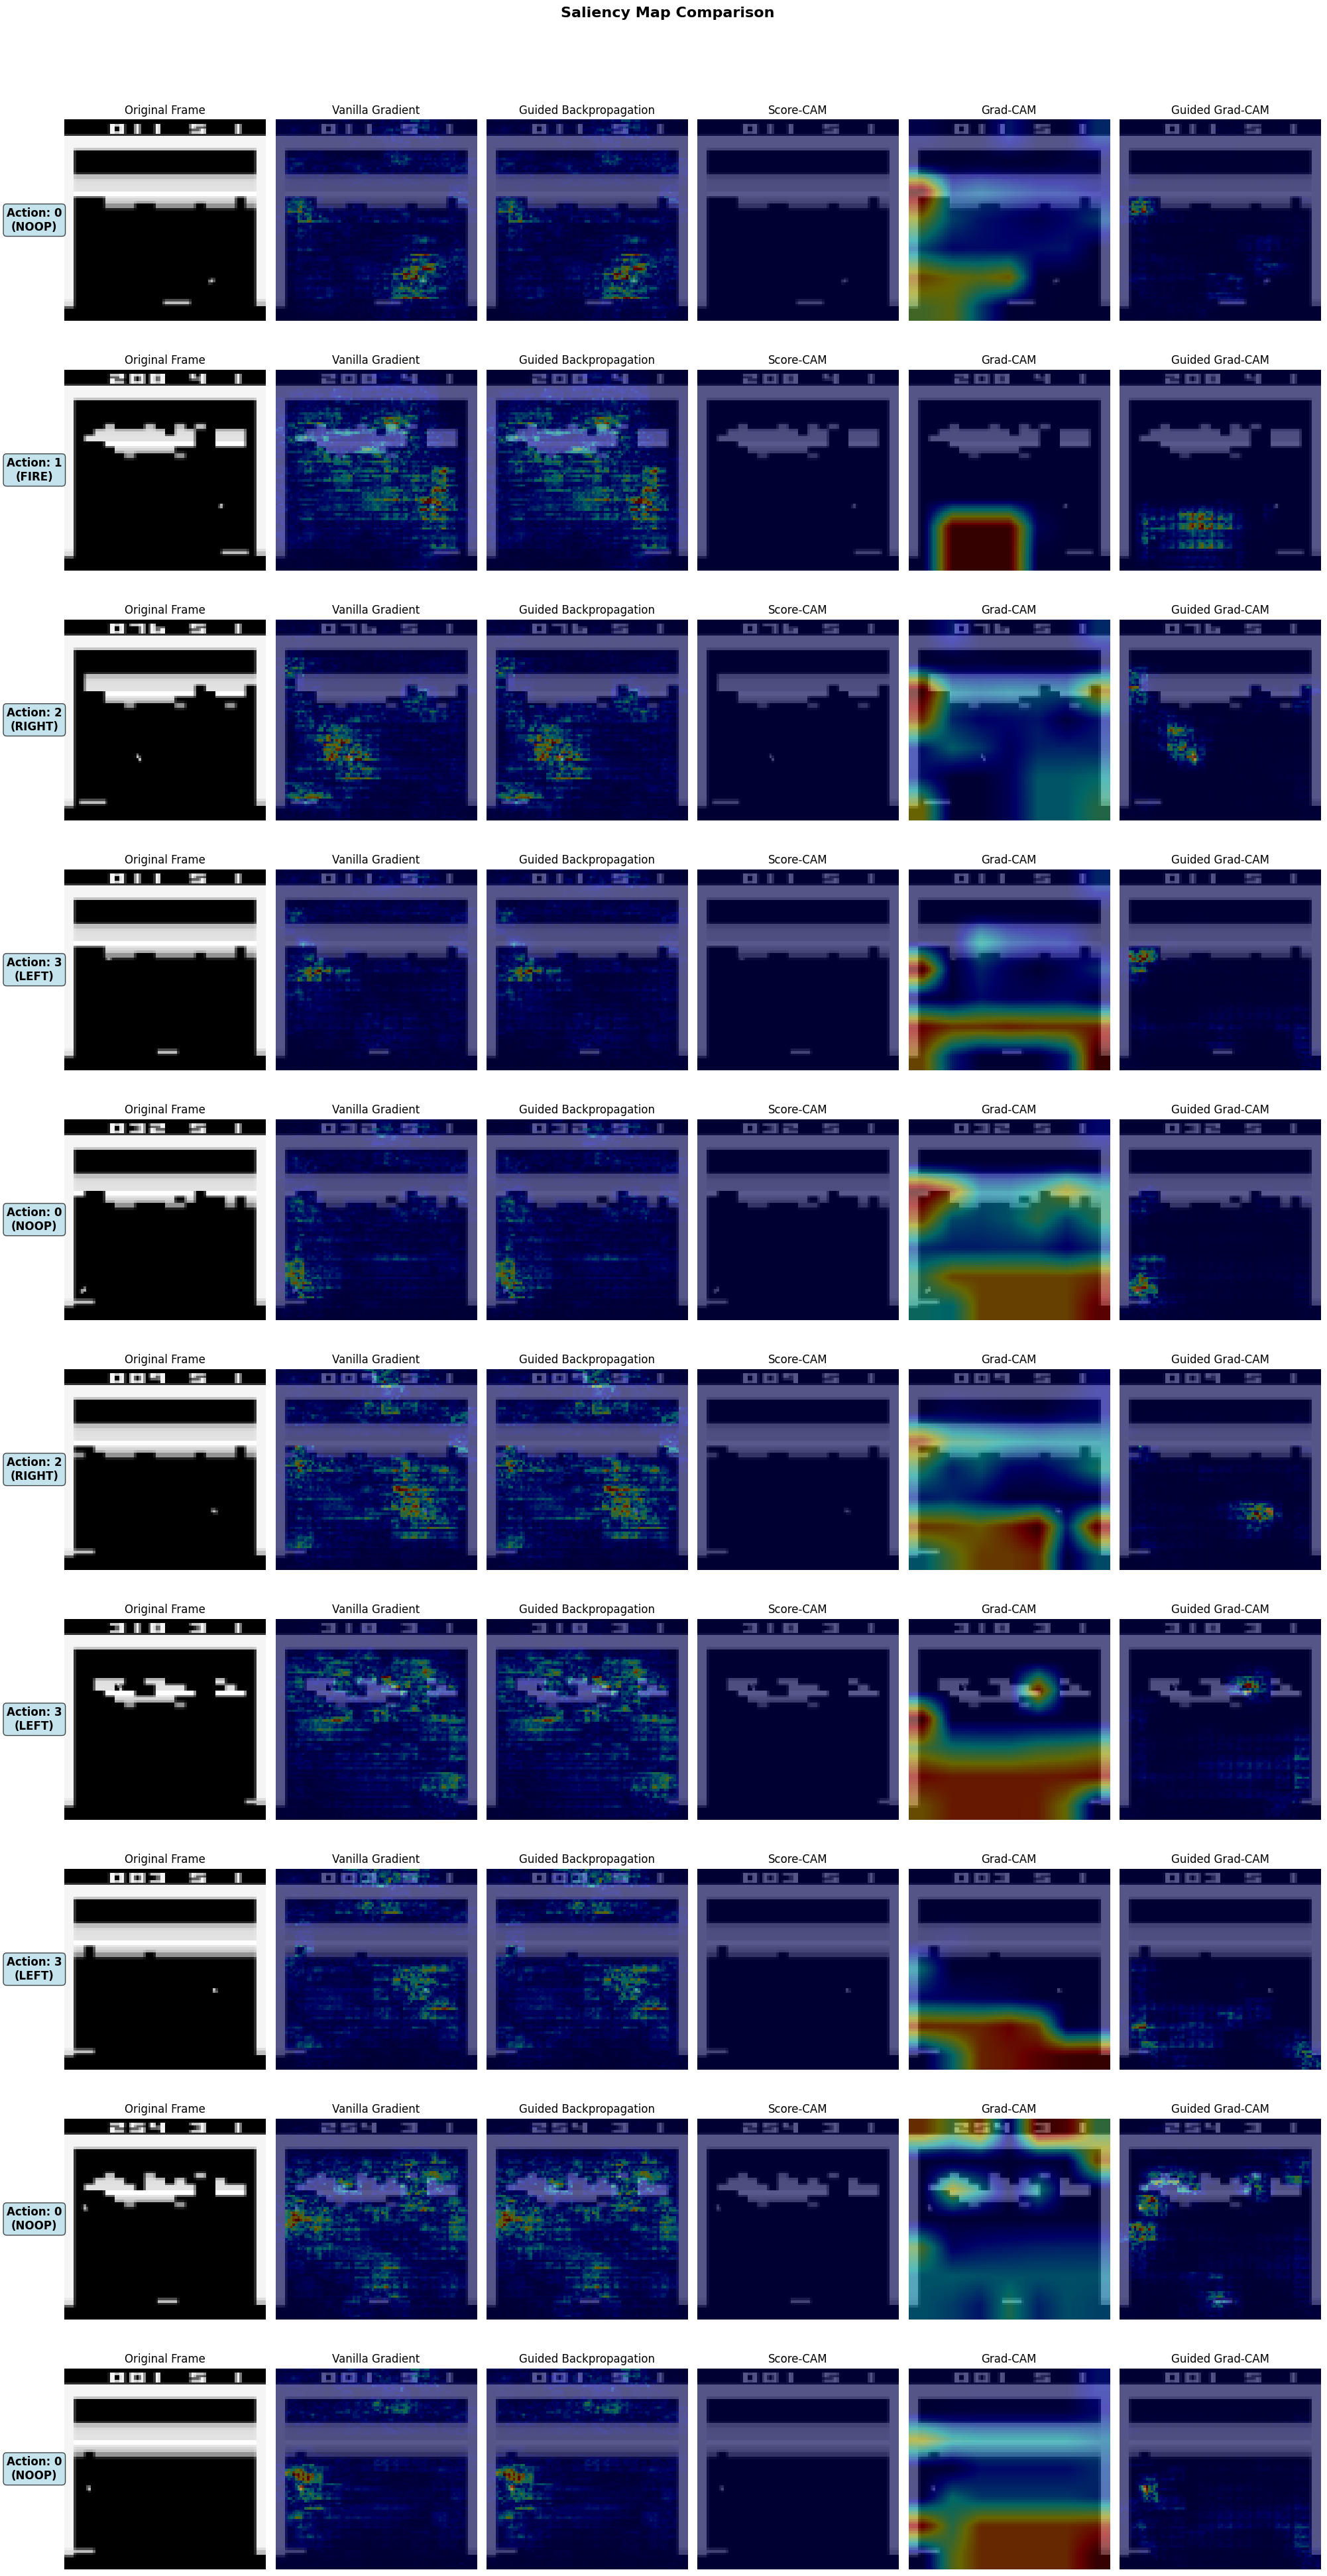

Action meanings in Breakout:
0: NOOP, 1: FIRE, 2: RIGHT, 3: LEFT


In [22]:
action_meanings = {0: "NOOP", 1: "FIRE", 2: "RIGHT", 3: "LEFT"}

random.seed(RANDOM_SEED)
transitions_sample = random.sample(transitions, 10)

fig, axes = plt.subplots(
    len(transitions_sample), 6, figsize=(20, 4 * len(transitions_sample))
)
fig.suptitle("Saliency Map Comparison", fontsize=16, fontweight="bold")

for row_idx, t in enumerate(transitions_sample):
    vanilla_map = vanilla_grad.generate_superimposed_map(t.state, t.action)
    smooth_map = smooth_grad.generate_superimposed_map(t.state, t.action)
    guided_backprop_map = guided_backprop.generate_superimposed_map(t.state, t.action)
    score_cam_map = score_cam.generate_superimposed_map(t.state, t.action)
    grad_cam_map = grad_cam.generate_superimposed_map(t.state, t.action)
    guided_grad_cam_map = guided_grad_cam.generate_superimposed_map(t.state, t.action)

    last_frame = t.state[0, :, :, -1]  # get the most recent frame

    action_name = action_meanings.get(t.action[0], "UNKNOWN")

    axes[row_idx, 0].imshow(last_frame, cmap="gray")
    axes[row_idx, 0].set_title("Original Frame")
    axes[row_idx, 0].axis("off")

    axes[row_idx, 1].imshow(vanilla_map)
    axes[row_idx, 1].set_title("Vanilla Gradient")
    axes[row_idx, 1].axis("off")

    axes[row_idx, 2].imshow(guided_backprop_map)
    axes[row_idx, 2].set_title("Guided Backpropagation")
    axes[row_idx, 2].axis("off")

    axes[row_idx, 3].imshow(score_cam_map)
    axes[row_idx, 3].set_title("Score-CAM")
    axes[row_idx, 3].axis("off")

    axes[row_idx, 4].imshow(grad_cam_map)
    axes[row_idx, 4].set_title("Grad-CAM")
    axes[row_idx, 4].axis("off")

    axes[row_idx, 5].imshow(guided_grad_cam_map)
    axes[row_idx, 5].set_title("Guided Grad-CAM")
    axes[row_idx, 5].axis("off")

    # Add action information as text annotation positioned relative to the subplot
    axes[row_idx, 0].text(
        -0.15,
        0.5,
        f"Action: {t.action[0]}\n({action_name})",
        fontsize=12,
        fontweight="bold",
        ha="center",
        va="center",
        transform=axes[row_idx, 0].transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
